# ExplorerLand data
https://explorer.land

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape, Polygon, MultiPolygon, LineString, MultiLineString, Point, MultiPoint
import json
import requests
import time
from random import uniform

In [2]:
projects = pd.DataFrame()
for page in range(0, 10):
    url = f"https://api.explorer.land/v1/public/projects?listed=1&status_ids[]=e6b4q7jev3n8xd50&status_ids[]=exm7vzjapj0r5846&order_by_status=1&include=activity_types,ecosystem_types,partners,tabs,countries,modules&limit=1000&page={page}"
    response = requests.get(url).json()
    projects = pd.concat([projects, pd.json_normalize(response['data'], sep='_')], ignore_index = True)

In [3]:
projects = projects.rename(columns = {'slug':'project_id_reported','long_description':'project_description_reported'})

In [4]:
projects

,object,id,project_id_reported,name,slogan,description,project_description_reported,title,video_url,video_thumbnail_url,...,sponsorship_sponsor_count,funding_opportunities_count,geojson_type,geojson_coordinates,partners_data,activity_types_data,ecosystem_types_data,modules_data,tabs_data,countries_data
0,Project,xm7vzjal8030r584,quintasoldolival,Quinta sol do olival,Agroecology experimentations for the people by...,"As we advance in this century, human touch wit...",We are located in the central part of Portugal...,6bP0Qnhz626RqnnLsMx3ToViiuEw0QhmlWa3ubHA.jpg,None,None,...,0,0,Point,"[-7.436854, 40.707092]",[],"[{'object': 'Tag', 'id': 'opxazw3gvw3dlmr4', '...","[{'object': 'Tag', 'id': 'lwn9v8ydxejz0xrm', '...",[],"[[forests-forward], [about], [news], [goods], ...","[{'id': '4eondw3o4vjpgalk', 'name': 'Portugal ..."
1,Project,x7qrdn37ma34abmz,corridors_oued_tine,Corridors Caroubier ''ممرات خروب كابت كربون تغ...,Ici on plante du caroubier pour le climat ! هن...,"Le projet C6 ""Corridor Caroubier CAPTE Carbone...",L’ambition de Cx6 est de contribuer à la struc...,JGah6hlCQVtB7SBVFwTK9jRXd2ovnitsQJNBEgpz.jpg,https://youtube.com/embed/2vCu93ArkXA,https://img.youtube.com/vi/2vCu93ArkXA/hqdefau...,...,0,0,Point,"[9.714216, 36.894821]","[{'object': 'Partner', 'id': 'vg0drw387myx4z9q...","[{'object': 'Tag', 'id': 'xabwdoj4eoykm8zg', '...","[{'object': 'Tag', 'id': 'lwn9v8ydxejz0xrm', '...","[{'name': 'project_commodity_sales', 'legacy_n...","[[forests-forward], [about], [news], [sponsors...","[{'id': '6qorwg35rbj04kem', 'name': 'Tunisia (..."
2,Project,9xdbkyw48ljogwmz,ecotours,Sierra Gorda: Destino Sustentable Earth Check,None,La Alianza por la Conservación de la Sierra Go...,"En una primicia para América del Norte, la Res...",aUPx6Cly4QaXAFGg9vqiN1VutHNhCRhwTvGCiehl.jpg,None,None,...,0,0,Point,"[-99.557794, 21.279256]","[{'object': 'Partner', 'id': 'omper39aamjgxwq0...","[{'object': 'Tag', 'id': '6qorwg359gj04kem', '...",[],"[{'name': 'project_commodity_sales', 'legacy_n...","[[forests-forward], [about], [news], [goods], ...","[{'id': 'ow54el3pqdj9znaq', 'name': 'Mexico (M..."
3,Project,wn9v8ydmewyz0xrm,elearningplatform,ABALOBI's Coach Based E-Learning & Training: A...,"Catch Knowledge, Sustain Futures with ABALOBI ...",ABALOBI's e-learning platform offers a compreh...,The ABALOBI e-learning platform is revolutioni...,VB5ARfwRZ0UwkN4juOvd6Os9qOmtqxKDdJYijZYo.jpg,None,None,...,0,0,Point,"[18.489139, -34.087351]",[],"[{'object': 'Tag', 'id': 'x7qrdn37oky4abmz', '...",[],[],"[[forests-forward], [about], [news], [goods], ...","[{'id': 'x7qrdn37da34abmz', 'name': 'South Afr..."
4,Project,9xdbkywvgdjogwmz,fwasmarketplace,"The ""Fish With A Story"" MARKETPLACE Platform",Fish with a social and ecological story: rethi...,"""Fish With A Story"" – by ABALOBI – is fully tr...","# ""Fish with a Story""\r\nA Story on a plate .....",QrpxX7BfHF84e9cehqNdq9rv3J4NcbtLwtIP5gm6.jpg,https://youtube.com/embed/yOqBbFCU344,https://img.youtube.com/vi/yOqBbFCU344/hqdefau...,...,0,0,Point,"[18.813381, -34.102679]","[{'object': 'Partner', 'id': '0waln3ko5bj4bg5r...","[{'object': 'Tag', 'id': 'ow54el3p0ly9znaq', '...","[{'object': 'Tag', 'id': 'opxazw3ggl3dlmr4', '...",[],"[[forests-forward], [about], [news], [goods], ...","[{'id': 'x7qrdn37da34abmz', 'name': 'South Afr..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,Project,9nz6b3v7gb38eaql,gatopreto,SDGs Families,None,We have worked with communities of Lake Distri...,Mozambique is one of the countries most affect...,s2rg1x98xsCYynSFdjRIm7ZtL5HkN7EWpCHL37Wz.jpg,None,None,...,0,0,Point,"[34.689098, -12.439639]","[{'object': 'Partner', 'id': '7qrdn37rezy4abmz...","[{'object': 'Tag', 'id': 'opxazw3gvw3dlmr4', '...","[{'object': 'Tag', 'id': 'opxazw3ggl3dlmr4', '...",[],"[[forests-forward], [about], [news], [goods], ...","[{'id': '6ln5pa3mznj9ogex', 'name': 'Mozambiqu..."
920,Project,abwdoj4e45ykm8zg,african_bamboo_munesa,Socially Responsible Bamboo Plantation,None

In [5]:
sites = pd.DataFrame()
for project in projects.project_id_reported.unique().tolist():
    url = f"https://api.explorer.land/v1/public/spots/polygon?project_slug={project}"
    response = requests.get(url).json()
    if response['features']:
        temp = pd.json_normalize(response['features'], sep='_')
        temp['project_id_reported'] = project
        sites = pd.concat([sites, temp], ignore_index = True)
        time.sleep(uniform(0, 5.0))

In [6]:
raw_df = sites.copy()

In [7]:
raw_df["geometry"] = raw_df["geometry_coordinates"].apply(lambda coords: MultiPolygon([Polygon(p[0]) for p in coords]))

In [8]:
gdf = gpd.GeoDataFrame(raw_df, geometry='geometry', crs = 'EPSG:4326')

### Fix geometries

Combine linestrings to polygons, if applicable

In [10]:
gdf['geometry'] = gdf['geometry'].apply(
    lambda geom: Polygon(list(geom.coords) + [geom.coords[0]]) if isinstance(geom, LineString) and not geom.is_closed and len(geom.coords) > 0 else
                 Polygon(geom.coords) if isinstance(geom, LineString) and geom.is_closed else
                 geom
)

Explode multipolygons to individual polygons

In [11]:
while 'MultiPolygon' in gdf.geometry.geom_type.unique().tolist():
    gdf = gdf.explode(index_parts=False)
    gdf['geometry'] = gdf['geometry'].make_valid()

Keep only polygons and points

In [12]:
gdf = gdf.loc[gdf.geometry.geom_type.isin(['Polygon', 'Point'])].copy()

Keep only reforestation sites

In [13]:
gdf = gdf.loc[gdf.properties_category_label == 'Reforestation']

Create site-level id

In [14]:
gdf = gdf.reset_index(drop = True).reset_index(names=['site_id_created'])

Add project-level description

In [15]:
gdf = (gdf
       .loc[:, ['site_id_created', 'properties_slug', 'project_id_reported', 'properties_description', 'geometry']]
       .rename(columns = {'properties_slug':'site_id_reported','properties_description':'site_description_reported'})
       .merge(projects[['project_id_reported', 'project_description_reported']], on = 'project_id_reported', how = 'left')
       .drop_duplicates()
       .reset_index(drop = True))

### Fix geometries

In [21]:
invalid_geom = False

if len(gdf[gdf.geometry.is_valid == False]) > 0:
    invalid_geom = True    

### Harmonize nomenclature

In [22]:
gdf['host_name'] = 'Explorer Land'
gdf['url'] = 'https://explorer.land/x/project/' + gdf.project_id_reported + '/site/' + gdf.site_id_reported + '/about'
gdf['site_sqkm'] = gdf['geometry'].to_crs('EPSG:3857').area / 1e6
gdf['project_geometries_invalid'] = invalid_geom

<Axes: >

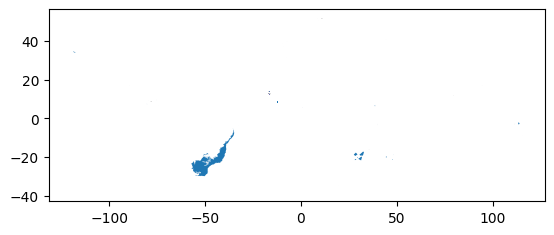

In [23]:
gdf.plot()

In [18]:
gdf['site_sqkm'].describe()

count    3.243000e+03
mean     5.201735e+02
std      2.336132e+04
min      1.271401e-14
25%      1.197717e-03
50%      2.533558e-02
75%      9.115859e-02
max      1.298818e+06
Name: site_sqkm, dtype: float64

In [25]:
gdf["project_geometries_invalid"].value_counts()

project_geometries_invalid
False    3243
Name: count, dtype: int64

### Save it

In [26]:
gdf.to_file("../midsave/explorer_land.gpkg")